In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)  # increase default figure size

np.random.seed(2016)  # for reproducibility

# Ising Model


Στην άσκηση αυτή θα χρησιμοποιήσουμε τον αλγόριθμο **Metropolis-Hastings** για να
κάνουμε δειγματοληψία από την αναλλοίωτη κατανομή $\pi$ του μοντέλου [Ising](https://en.wikipedia.org/wiki/Ising_model). 
Στο επόμενο κελί κώδικά θεωρούμε πλέγμα μήκους `L = 32`, 
οπότε ο χώρος $\mathbb{X}$ των δυνατών διαμορφώσεων έχει πληθάριθμο $2^{1024} > 10^{307}$. 
Καταλαβαίνει κανείς ότι η δειγματοληψία από έναν τόσο μεγάλο χώρο είναι
πρακτικά αδύνατη με συμβατικές μεθόδους. 


In [8]:
# Parameters
L = 32  # length of lattice
N = L * L  # number of particles
nsteps = N * 800  # number of updates, we will update each spin 800 times on average 
Temperature = 30.  # in units where the Boltzmann factor is 1

# Initialize Variables
spins = 2 * (np.random.rand(L, L) > 0.5) - 1  # random initial state (table of {1, -1})
kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

for n in range(nsteps):
    r, c = np.random.randint(0, L, 2)  # select a vertex (row, column) at random
    # indices of a box around r, c
    C = [(c-1) % L, c % L, (c + 1) % L]  # periodic boundary conditions, i.e. (0,x) is a neighbour of (L-1,x) 
    R = [[(r-1) % L], [r % L], [(r+1) % L]]
    DH = spins[r, c] * np.sum(kernel * spins[R, C]) # check the textbook to see why this expression is ΔΗ
    if np.random.rand() < np.exp(- DH / Temperature):  # think why this realizes Metropolis-Hastings (discussed in class)
        spins[r, c] *= -1  # flip spin 


Ο κώδικας χρησιμοποιεί τον αλγόριθμο Metropolis-Hastings 
για να προσομοιώσει μια μαρκοβιανή αλυσίδα στον $\mathbb{X}$ 
που ξεκινά από μια τυχαία αρχική διαμόρφωση (`spins`) και έχει αναλλοίωτη κατανομή το μέτρο Gibbs που αντιστοιχεί στην ενέργεια του μοντέλου Ising, δηλαδή

$$H(\sigma)=-\sum_{x,y: x~y} \sigma(x)\sigma(y)$$
και
$$\pi(\sigma)=\frac{e^{-\beta H(\sigma)}}{Z(\beta)}$$
όπου η συνάρτηση επιμερισμού $Z(\beta)$ δίνεται από την
$$Z(\beta)=\sum_{\sigma\in\mathbb{X}} e^{-\beta H(\sigma)}.$$


Σε κάθε επανάληψη (`nsteps`)
επιλέγει τυχαία ένα σημείο του πλέγματος (`r, c`) και υπολογίζει τη διαφορά στην ενέργεια 
του συστήματος (`DH`) αν το spin σε εκείνο το σημείο αλλάξει πρόσημο. 
Στη συνέχεια δέχεται η απορρίπτει την αλλαγή spin με πιθανότητα $e^{-\beta (DH)^+}$, όπως ορίζει ο αλγόριθμος Metropolis-Hastings.

Στο επόμενο κελί κώδικα οπτικοποιούμε την τελική κατάσταση του συστήματος

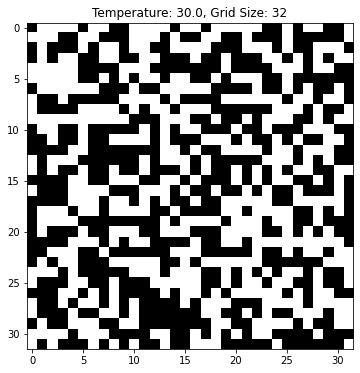

In [9]:
plt.imshow(spins, cmap='binary', vmin=-1, vmax=1, interpolation='nearest')
plt.title("Temperature: %.1f, Grid Size: %d" % (Temperature, L))
plt.show()

Δοκιμάσετε να ξανατρέξετε τα 2 προηγούμενα κελιά και δείτε πώς αλλάζει (αν αλλάζει) η τελική διάταξη του πλέγματος

### Ising Parameters

Για να αποκτήσουμε μια καλύτερη διαίσθηση για το πως λειτουργεί το σύστημα,
θα μελετήσουμε την συμπεριφορά του αν πειράξουμε τις διάφορες παραμέτρους.

Πρώτα θα δούμε πώς η ενέργεια επηρεάζει την πιθανότητα αλλαγής σπιν.
Στο παρακάτω κελί κώδικα πλοτάρουμε την πιθανότητα μετάβασης για όλες τις
πιθανές τιμές τις ενέργειας.

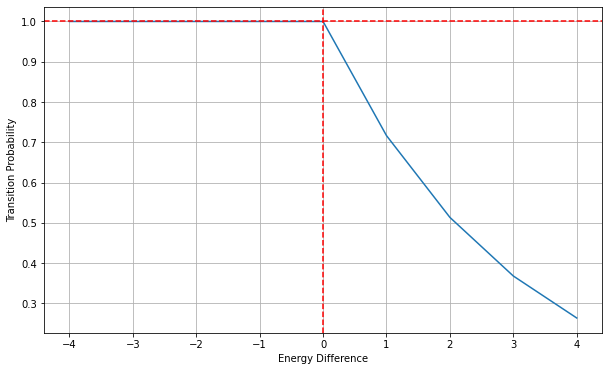

In [10]:
x = np.arange(-4, 5)  # all possible DH after a spin flip
Temperature = 3.0
y = np.exp(-np.maximum(x,0) / Temperature)  
plt.plot(x, y)
plt.xlabel("Energy Difference")
plt.ylabel("Transition Probability")
plt.grid(True)
plt.axvline(0, color='red', linestyle='dashed')
plt.axhline(1, color='red', linestyle='dashed')
plt.show()

Παρατηρήστε ότι όταν η ενέργεια του συστήματος μειώνεται (`DH < 0`),
ο αλγόριθμος δέχεται αυτομάτως την προτεινόμενη αλλαγή. Αντιθέτως όταν η ενέργεια του συστήματος αυξάνεται,
ο αλγόριθμος δεν απορρίπτει αμέσως την αλλαγή αλλά την δέχεται με φθίνουσα πιθανότητα.

Στο επόμενο κελί κώδικα δοκιμάζουμε διάφορες θερμοκρασίες και βλέπουμε πως αυτές επηρεάζουν
την πιθανότητα αλλαγής σπιν.

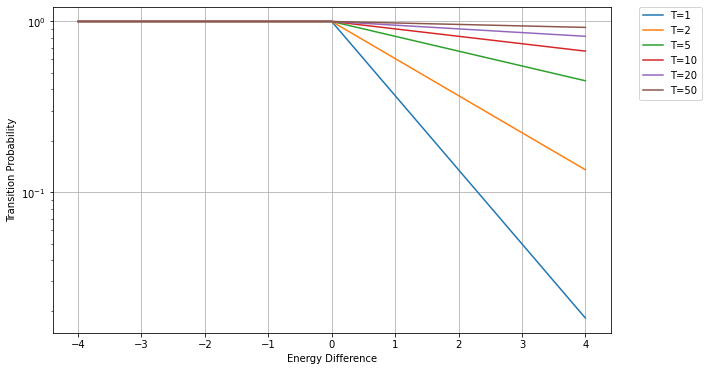

In [11]:
temperatures = [1, 2, 5, 10, 20, 50]
cmap = plt.cm.get_cmap('Dark2')
colors = [cmap(x) for x in np.linspace(0, 1, 6)]

for col, temp in zip(colors, temperatures):
    y = np.exp(-np.maximum(x,0) / temp)
    plt.semilogy(x, y, label='T=%d' % temp)

plt.xlabel("Energy Difference")
plt.ylabel("Transition Probability")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

Παρατηρήστε πώς η θερμοκρασία (`Τ`) "ελέγχει" την κλίση του λογαρίθμου της πιθανότητας μετάβασης.
Μικρή θερμοκρασία (και άρα μεγάλη κλίση) σημαίνει ότι η αλύσιδα είναι πολύ ευαίσθητη
σε αλλαγές της ενέργειας, επομένως οι μόνες αλλαγές που δέχεται είναι αυτές που
μειώνουν την ενέργεια του συστήματος ή την αυξάνουν ελάχιστα. Αντίθετα, μεγάλη θερμοκρασία
(και άρα μικρή κλίση) σημαίνει ότι η αλυσίδα αδιαφορεί ουσιαστικά για
την ενέργεια του συστήματος και δέχεται κάθε προτεινόμενη αλλαγή καθώς όπως βλέπουμε
η πιθανότητα αλλαγής σπιν είναι κοντά στη μονάδα.

### Ising Animation

Για το επόμενο κελί κώδικα χρειάζεται να έχετε στον ίδιο φάκελο με τον notebook το
script `animate_ising.py`. Αυτό το script οπτικοποιεί σε "βίντεο" την εξέλιξη του
πλέγματος των σπιν.

Δέχεται 3 ορίσματα

1. `-L`: το μέγεθος του πλέγατος
2. `-Temp`: τη θερμοκρασία
3. `-up`: το ποσοστό των σπιν που είναι αρχικά θετικά

Δοκιμάστε να τρέξετε το παρακάτω κελί αφού σβήσετε το `#` από τις πρώτες 2 γραμμές
ανάλογα με το λειτουργικό σας σύστημα καθώς και το σχόλιο δίπλα. Αν δεν τρέξει, ανοίξτε ένα παράθυρο εντολών (Terminal) και από τον φάκελο που έχετε αποθηκεύσει το αρχείο `animate_ising.py` δώστε την εντολή `python3 animate_ising.py -T 0.1 -L 32 -up 0.5`

In [28]:
%matplotlib qt 
#uncomment this line if you have Windows
#%matplotlib tk
#uncomment this line if you have Linux
%run animate_ising.py -T 0.1 -L 32 -up 0.5

Το βίντεο συνεχίζει σε αέναο βρόχο, οπότε για να το σταματήσετε απλά κλείστε το παράθυρο.
Αφήστε όμως το πρόγραμμα να τρέξει για αρκετό χρόνο ώστε να δείτε το σύστημα να καταλήγει 
σε μια κατάσταση με τα σπιν οργανωμένα (είτε σχεδόν όλα +1, είτε σχεδόν όλα -1).
Όταν το κλείσετε εκτελέστε το επόμενο κελί κώδικα αν θέλετε τα επόμενα γραφήματα αυτού του
notebook να εμφανίζονται μέσα στο notebook (και όχι pop-out)

In [13]:
%matplotlib inline

Στο παρακάτω κελί κώδικα σας δίνουμε την συνάρτηση `Ising` αν θελήσετε να την χρησιμοποιήσετε για τις
ασκήσεις σας. Για να την τρέξετε χρειάζεται να δώσετε:

1. Την αρχική κατάσταση του πλέγματος (ένα numpy array με -1 και 1)
2. Τη θερμοκρασία
3. (προαιρετικά) τον αριθμό των βημάτων

In [14]:
def Ising(spins_init, Temp, nsteps=None):
    """
    Ising Model.
        spins_init: initial configuration
        Temp: the Temperature
        updates: the number of updates to perform
    """
    spins = spins_init.astype(np.int8)  # copy and save some space :)
    L = spins.shape[0]
    N = L * L
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=np.int8)
    Temp = Temp
    if nsteps is None:
        nsteps = L * L * 800  # number of updates

    for n in range(nsteps):
        r, c = np.random.randint(0, L, 2)  # select a vertex at random
        C = [(c-1) % L, c % L, (c + 1) % L]
        R = [[(r-1) % L], [r % L], [(r+1) % L]]
        DH = -spins[r, c] * np.sum(kernel * spins[R, C]) / Temp
        if np.log(np.random.rand()) < DH:
            spins[r, c] *= -1  # switch sign
    
    return spins

## Παραδοτέα

α) Δοκιμάστε να τρέξετε τον κώδικα με όλα τα spin αρχικά στο +1. 
Τρέξτε τον μερικές φορές. Αλλάζουν τα ποιοτικά χαρακτηριστικά 
της διαμόρφωσης που επιστρέφει ο αλγόριθμος;

β) Με όλα τα spin αρχικά τυχαία, αρχίστε τώρα να κατεβάζετε τη θερμοκρασία, θέτοντας διαδοχικά 
T = 30, 10, 5, 2, 1.5, 1., 0.5, 0.1, 0.01. Δείξτε για κάθε θερμοκρασία την εικόνα που πήρατε.

Η μαγνήτιση του συστήματος ορίζεται ως ο μέσος όρος των σπιν του πλέγματος Λ, δηλαδή

$$ m(\sigma) = \frac{1}{|\Lambda|} \sum_{k \in \Lambda} \sigma(k) $$

γ) Εξετάστε πώς συμπεριφέρεται η $m(\sigma)$ για τις καταστάσεις $\sigma$ 
που δίνει ο αλγόριθμος καθώς κατεβάζετε τη θερμοκρασία, όπως στο ερώτημα (β).
Δείξτε μια γραφική παράσταση της $m(\sigma)$ ως προς τη θερμοκρασία (για τη διαμόρφωση $\sigma$ που προσομοιώσατε).

δ) Για τη θερμοκρασία `T = 0.1` αλλάξτε την τιμή της παραμέτρου nsteps. Πώς μοιάζουν τα ενδιάμεσα στάδια από τα οποία περνάει η αλυσίδα μέχρι να καταλήξουμε στην εικόνα που πήραμε για `nsteps = 800 × L × L`; Δείξτε τις εικόνες που πήρατε για 
`nsteps=10,20,50,100,200,400,800  × L × L`